## Let's dive into our model's predictions for stage 1

**Questions to ask:**
  - Which games did it get wrong?
  - What do those games have in common?
  - Would including those features be risking "overfitting" to these few years (2015-2019)?

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

plt.style.use('fivethirtyeight')

## Utility Scripts
import sys
sys.path.append("../")
import data_utils as du  ## one made by us


os.chdir("../../data/women")

In [2]:
## Provided files
teams = pd.read_csv("WTeams.csv")
seeds = pd.read_csv("WNCAATourneySeeds.csv")
tourney_results = pd.read_csv("WNCAATourneyCompactResults.csv")
teams_and_seeds = teams.merge(seeds)

## Our submission
submission = pd.read_csv("subs/submission_probs_full_2021-03-10.csv")

## Create matching ID on tourney_results
tourney_results['ID'] = tourney_results.apply(lambda x: f"{x['Season']}_{x['WTeamID']}_{x['LTeamID']}"
                                              if x['WTeamID'] < x['LTeamID']
                                              else f"{x['Season']}_{x['LTeamID']}_{x['WTeamID']}", axis=1)
## Create binary target
tourney_results['Team1_Win'] = tourney_results.apply(lambda x: 1 if x['WTeamID'] < x['LTeamID'] else 0, axis=1)

## Merge with predictions and calculate a residual
tourney_results = tourney_results.merge(submission)
tourney_results['residual'] = tourney_results['Team1_Win'] - tourney_results['Pred']
tourney_results['abs_residual'] = np.abs(tourney_results['residual'])

## Merge in team names and seeds
teams_and_seeds = teams_and_seeds.rename(columns = {'TeamName': 'WTeamName',
                                                    'Seed': 'WSeed',
                                                    'TeamID': 'WTeamID'})
tourney_results = tourney_results.merge(teams_and_seeds)
teams_and_seeds = teams_and_seeds.rename(columns = {'WTeamName': 'LTeamName',
                                                    'WSeed': 'LSeed',
                                                    'WTeamID': 'LTeamID'})
tourney_results = tourney_results.merge(teams_and_seeds)

In [3]:
## Change 1/2 variables into W/L
tourney_results['W_lower_higher_avg'] = tourney_results.apply(lambda x: x['lower_higher_avg_1'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['lower_higher_avg_2'], axis=1)
tourney_results['L_lower_higher_avg'] = tourney_results.apply(lambda x: x['lower_higher_avg_2'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['lower_higher_avg_1'], axis=1)
tourney_results['W_team_avg_round'] = tourney_results.apply(lambda x: x['team_avg_round_1'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['team_avg_round_2'], axis=1)
tourney_results['L_team_avg_round'] = tourney_results.apply(lambda x: x['team_avg_round_2'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['team_avg_round_1'], axis=1)
tourney_results['WConfAbbrev'] = tourney_results.apply(lambda x: x['ConfAbbrev_1'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['ConfAbbrev_2'], axis=1)
tourney_results['LConfAbbrev'] = tourney_results.apply(lambda x: x['ConfAbbrev_2'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['ConfAbbrev_1'], axis=1)
tourney_results['W_rank_in_conf'] = tourney_results.apply(lambda x: x['rank_in_conf_1'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['rank_in_conf_2'], axis=1)
tourney_results['L_rank_in_conf'] = tourney_results.apply(lambda x: x['rank_in_conf_2'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['rank_in_conf_1'], axis=1)
tourney_results['W_od_margin'] = tourney_results.apply(lambda x: x['od_margin_1'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['od_margin_2'], axis=1)
tourney_results['L_od_margin'] = tourney_results.apply(lambda x: x['od_margin_2'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['od_margin_1'], axis=1)


### Biggest misclassifications

Which games were we most confident in that ended up being the biggest upsets according to our model?

In [6]:
pd.options.display.max_columns = None

tourney_results[['Season', 'WTeamName', 'LTeamName', 'WScore', 'LScore', 'WSeed', 'LSeed',
                 'lower_higher_avg_diff', 'W_lower_higher_avg', 'L_lower_higher_avg', 
                 'WConfAbbrev', 'W_rank_in_conf', 'LConfAbbrev', 'L_rank_in_conf', 'W_team_avg_round',
                 'L_team_avg_round', 'delta_od_margin', 'W_od_margin', 'L_od_margin', 'Pred',
                 'abs_residual']].drop_duplicates().sort_values('abs_residual', ascending = False).head(20)

,Season,WTeamName,LTeamName,WScore,LScore,WSeed,LSeed,lower_higher_avg_diff,W_lower_higher_avg,L_lower_higher_avg,WConfAbbrev,W_rank_in_conf,LConfAbbrev,L_rank_in_conf,W_team_avg_round,L_team_avg_round,delta_od_margin,W_od_margin,L_od_margin,Pred,abs_residual
175,2017,Oregon,Maryland,77,63,W10,W03,3.8,0.0,3.8,NaN,NaN,big_ten,1.0,NaN,3.8,24.671364,8.866283,33.537647,0.955700,0.955700
174,2017,Oregon,Duke,74,65,W10,W02,2.6,0.0,2.6,NaN,NaN,acc,2.0,NaN,2.6,15.733908,8.866283,24.600191,0.932856,0.932856
123,2016,Washington,Maryland,74,65,Y07,Y02,3.2,0.6,3.8,pac_twelve,5.0,big_ten,1.0,0.2,3.8,20.341504,11.876918,32.218422,0.916643,0.916643
224,2018,Buffalo,Florida St,86,65,W11,W03,-4.0,0.2,4.2,mac,2.0,acc,3.0,0.2,3.0,-4.685903,18.388189,23.074092,0.101022,0.898978
297,2019,Missouri St,Iowa St,69,60,X11,X03,2.4,0.4,2.8,mvc,2.0,big_twelve,2.0,0.2,0.6,5.861123,14.134792,19.995915,0.887847,0.887847
12,2015,Gonzaga,Oregon St,76,64,X11,X03,-0.2,2.4,2.6,wcc,1.0,pac_twelve,1.0,2.4,0.4,-7.386803,15.148924,22.535727,0.129752,0.870248
226,2018,C Michigan,Ohio St,95,78,X11,X03,-2.6,0.2,2.8,mac,1.0,big_ten,1.0,0.2,1.6,-2.387499,15.122177,17.509676,0.129920,0.870080
213,2018,Oregon St,Baylor,72,67,Z06,Z02,1.4,2.4,3.8,pac_twelve,4.0,big_twelve,1.0,2.4,3.8,17.368885,23.146448,40.515333,0.863725,0.863725
231,2018,Creighton,Iowa,76,70,Y11,Y06,-1.4,0.0,1.4,NaN,NaN,big_ten,5.0,NaN,1.4,-9.893027,4.834916,14.727944,0.164875,0.835125
206,2018,Notre Dame,Connecticut,91,89,X01,W01,1.8,4.8,6.6,acc,2.0,aac,1.0,4.8,6.6,25.922678,23.634608,49.557285,0.834974,0.834974


In [7]:
#### Double checking missing values for avg. round by conf. standing and team
## Calculate standings for each conference and season
conf_standings_df = du.get_conf_win_pcts('women')

## Calculate rolling avg. round reached by conference standing
conf_stding_round_reached_df = du.get_rolling_avg_round_reached('women',
                    start_season = 2000, end_season = 2020, n_year_avg = 5)

## Calculate rolling avg. round reached by team
team_round_reached_df = du.get_rolling_avg_round_reached('women', by = 'coach/team',
                    start_season = 2000, end_season = 2020, n_year_avg = 5)

## Look for a couple of examples above with missing avg rounds by conf. standing and team
conf_standings_df = conf_standings_df.merge(conf_stding_round_reached_df, how = 'left')
conf_standings_df = conf_standings_df.merge(team_round_reached_df, how = 'left')
conf_standings_df = conf_standings_df.merge(teams, how = 'left')

conf_standings_df[((conf_standings_df['Season'] == 2017) & (conf_standings_df['TeamName'] == 'Oregon')) |
                  ((conf_standings_df['Season'] == 2016) & (conf_standings_df['TeamName'] == 'Auburn'))].head()

,Season,ConfAbbrev,TeamID,n_wins,n_losses,conf_win_pct,rank_in_conf,total_rounds_sum,Season_len,Season_max,Season_min,avg_rd_season_range,conf_avg_round,team_avg_round,TeamName
5974,2016,sec,3120,9,9,0.50000,8.0,5.0,2.0,2014.0,2012.0,2011-2015,1.0,NaN,Auburn
6526,2017,pac_twelve,3332,10,11,0.47619,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oregon


Observations:
 - Interestingly, Maryland was upset by pretty large margins in 2016 and 2017 in early rounds.  Maybe this is a sign that the Big 10 is overrated by our model?
    - Maybe not a good idea to bet against [Maryland's offense this year](https://fivethirtyeight.com/features/the-maryland-terrapins-are-lighting-up-the-scoreboard/)
 - The predictions are super aggressive for 1 seeds against other 1 seeds or 2 seeds.
    - Solution: Add `delta_Seed` variable from Kaggle utility script.
 - A couple of teams that did not appear in the last 5 previous tournaments and had a low conference standing that had also not appeared in the tournament in 5+ years (namely Oregon in 2017 and Auburn in 2016) were marked as huge underdogs because their `lower_higher_avg` is filled with 0 instead of missing.
    - Possible solution: We could impute the expected number of rounds for a team from a given conference to advance given their standing, but that doesn't seem right to give partial credit for not making the tournament.

### Do we need to "trim" our predictions to minimize log-loss?

See this [this notebook](https://www.kaggle.com/luisgarcia/should-you-have-trimmed-your-predictions-probably) for an overview of why it can be beneficial to trim confident predictions under the log-loss evaluation metric.

From the notebook:

    We search for  α  in the interval  [0,1/4]  to find the ideal  α . The function trimmed_loss(alpha) computes the log loss of the trimmed predictions against the truth. The minimum value is labeled in the plot and we see that some amount of trim would have benefited me in this competition, but too much trim is detrimental. The amount we shave off is actually minimal, but this can still lead to big movements on the leaderboard.

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

os.chdir("../../data/women")

## Results
tourney_results = pd.read_csv("WNCAATourneyCompactResults.csv")

## Our submission
submission = pd.read_csv("subs/submission_probs_2021-03-10.csv")

## Create matching ID on tourney_results
tourney_results['ID'] = tourney_results.apply(lambda x: f"{x['Season']}_{x['WTeamID']}_{x['LTeamID']}"
                                              if x['WTeamID'] < x['LTeamID']
                                              else f"{x['Season']}_{x['LTeamID']}_{x['WTeamID']}", axis=1)
## Create binary target
tourney_results['Team1_Win'] = tourney_results.apply(lambda x: 1 if x['WTeamID'] < x['LTeamID'] else 0, axis=1)

## Merge with predictions and calculate a residual
tourney_results = tourney_results.merge(submission)
tourney_results['residual'] = tourney_results['Team1_Win'] - tourney_results['Pred']
tourney_results['abs_residual'] = np.abs(tourney_results['residual'])

In [9]:
def trim_pred(x, alpha):
    upper = 1-alpha
    lower = alpha
    if x > upper:
        return upper
    if x < lower:
        return lower
    else: return x
    
def trimmed_loss(alpha):
    trimmed_preds = [trim_pred(x,alpha) for x in tourney_results.Pred]
    return log_loss(tourney_results.Team1_Win , trimmed_preds)

def annot_min(x,y, ax=None):
    minIxVal = np.argmin(y);
    zeroBasedIx = y[minIxVal];
    xmin = x[minIxVal];
    ymin = y[minIxVal]
    text = "Minimum: Trim Interval = [{}, {}], Log Loss = {}".format(round(xmin,2), round(1-xmin,2), round(ymin, 3))
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.1")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.90), **kw)


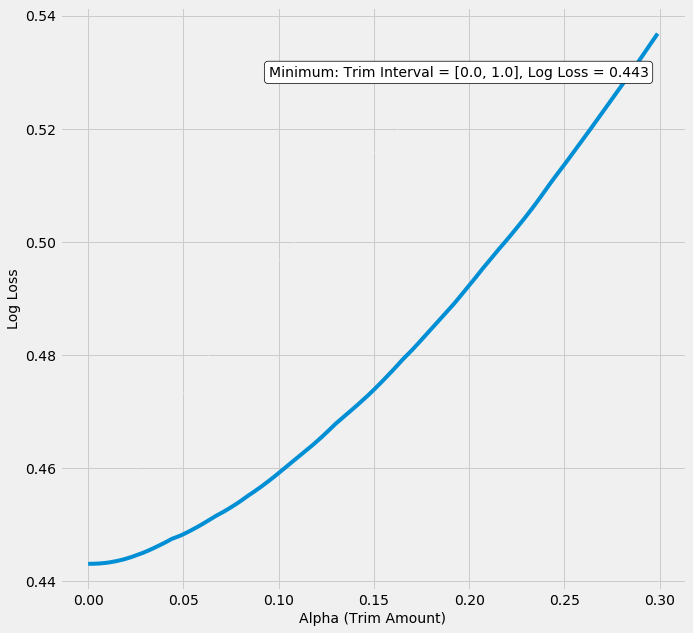

In [10]:
xvals = np.arange(0, .30, 0.001)
yvals = [trimmed_loss(alpha) for alpha in xvals]

plt.figure(figsize=(10,10))
plt.plot(xvals, yvals)
plt.xlabel('Alpha (Trim Amount)', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
annot_min(list(xvals),yvals, ax=None)
plt.show()

As it stands, our model would not benefit from "trimming" predictions in the 2015-2019 tournaments.  

Note that these tournaments did not have any major upsets, but it may also be likely that the women's tournament is less likely than the men's to see major upsets. Still, we may want to consider it to avoid catastrophe if there is a big upset.